# Chapter 14: Prediting Time Series with RNN Model

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['font.family'] = 'stixgeneral'

In [2]:
# 定义常用函数
def plotSeries(x,y,title='',second=False):
    if not second: plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.plot(x,y)

def plotHistory(histroy, zoom_size = 20):
    """显示结果列表"""
    mae = history.history['mae']
    loss = history.history['loss']
    epochs = range(len(loss))
   
    plt.figure(figsize=(10,6))
    plt.plot(epochs,mae,'r-^',label = 'MAE')
    plt.plot(epochs,loss,'b-*', label = 'Loss')
    plt.title('MAE and Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['MAE', 'Loss'])

    if zoom_size == 0: return None

    plt.figure(figsize=(10,6))
    plt.plot(epochs[zoom_size:],mae[zoom_size:],'r-^',label='MAE')
    plt.plot(epochs[zoom_size:],loss[zoom_size:],'b-*',label='Loss')
    plt.title('MAE and Loss with Zoom')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['MAE', 'Loss'])

def checkError(test, predict):
    '''计算并展示预测和测试集的误差'''
    print('均方误差:', keras.metrics.mean_squared_error(test, predict).numpy())
    print('平均绝对误差:', keras.metrics.mean_absolute_error(test, predict).numpy())

## Part 1: Generate Time Sequence and Labeled Data(Preprocessing)

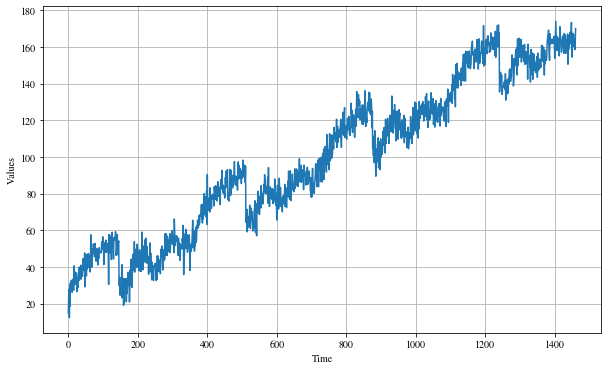

In [3]:
preiod = 365
repeat_time = 4
time = np.arange(preiod*repeat_time+1)

# Step1: 生成主要的上升趋势和基准线
slope = 0.1
baseline = 20

# Step2: 生成季节性的时间序列
def seasonality(time, period, amplitud=0, phase=0):
    interval = ((time+phase)%period)/period
    return amplitud*np.where(interval<0.4, np.tanh(interval*2*np.pi)**0.6, 1/np.exp(2*interval)*np.sin(interval*25))

# Step3: 生成噪音
def noise(time, amplifer=1):
    return np.random.randn(len(time))*amplifer

# 结合总体趋势，周期变化，噪声和基准线
series = baseline + time * slope + seasonality(time, period=365, amplitud=20) + noise(time, amplifer=5) 
plotSeries(time, series) 

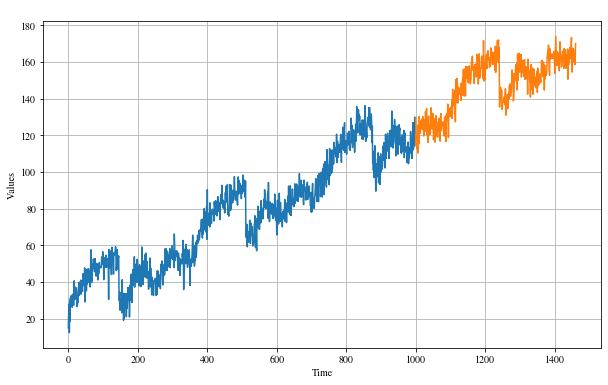

In [4]:
# 划分数据集
train_size = 1000
train_time = time[:train_size]
train_values = series[:train_size]
test_time = time[train_size:]
test_values = series[train_size:]

plotSeries(train_time, train_values, '训练数据集')
plotSeries(test_time, test_values, '测试数据集', second=True)

In [5]:
# 生成带标签的数据集，用于训练和校验
# 参数：时间序列，窗口大小，批次大小，随机缓存大小
# 输出：(特征，标签)
window_size = 20
batch_size = 128
shuffle_size = 1000
def windowedDataset(series, size, batch, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda windows: windows.batch(size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch).prefetch(1)
    return dataset


In [6]:
# 搭建SimpleRNN神经网络，使用LR_scheduler机制调整学习率
tf.keras.backend.clear_session() # Resets all state generated by Keras
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowedDataset(train_values, window_size, batch_size, shuffle_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

# 模型的4个参数：优化器、损失函数、度量指标、学习率

# 优化器：使用随机梯度下降法SGD，并防止局部最小值设置了一个冲量项
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

# 损失函数：使用了Huber Loss。他的优点是降低了对李三数据的惩罚，增强了鲁棒性。
# 度量值：使用MAE(平均绝对误差)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

# 学习率：根据epoch数来调整学习率
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))

history1 = model.fit(train_set, epochs=60, callbacks=[lr_schedule])

Epoch 1/60
8/8 [==============================] - 3s 139ms/step - loss: 181.3062 - mae: 181.8062
Epoch 2/60
8/8 [==============================] - 1s 137ms/step - loss: 181.3848 - mae: 181.8848
Epoch 3/60
8/8 [==============================] - 1s 139ms/step - loss: 179.4120 - mae: 179.9120
Epoch 4/60
8/8 [==============================] - 1s 119ms/step - loss: 176.5075 - mae: 177.0075
Epoch 5/60
8/8 [==============================] - 1s 114ms/step - loss: 171.7003 - mae: 172.2003
Epoch 6/60
8/8 [==============================] - 1s 119ms/step - loss: 166.6817 - mae: 167.1817
Epoch 7/60
8/8 [==============================] - 1s 127ms/step - loss: 159.7209 - mae: 160.2209
Epoch 8/60
8/8 [==============================] - 1s 118ms/step - loss: 149.9406 - mae: 150.4406
Epoch 9/60
8/8 [==============================] - 1s 126ms/step - loss: 139.3090 - mae: 139.8090
Epoch 10/60
8/8 [==============================] - 1s 123ms/step - loss: 128.9945 - mae: 129.4945
Epoch 11/60
8/8 [============

(1e-08, 0.0001, 0.0, 30.0)

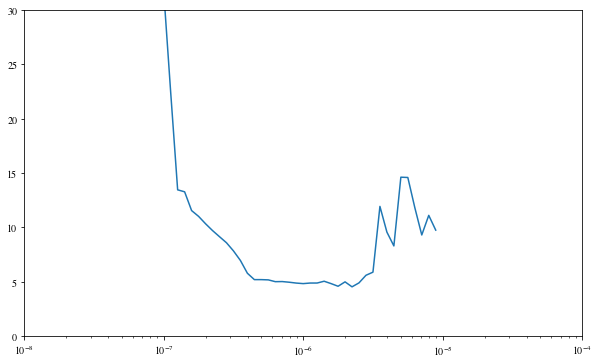

In [7]:
plt.figure(figsize=(10,6))
plt.semilogx(history1.history['lr'], history1.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [10]:
# 通过上个调整LR的模型和上图，找到最大的稳定的LR
tf.keras.backend.clear_session() # Resets all state generated by Keras
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowedDataset(train_values, window_size, batch_size, shuffle_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(train_set, epochs=300)

37ms/step - loss: 4.3000 - mae: 4.7779
Epoch 93/300
8/8 [==============================] - 1s 137ms/step - loss: 4.3579 - mae: 4.8335
Epoch 94/300
8/8 [==============================] - 1s 151ms/step - loss: 4.2970 - mae: 4.7759
Epoch 95/300
8/8 [==============================] - 1s 142ms/step - loss: 4.0257 - mae: 4.4950
Epoch 96/300
8/8 [==============================] - 1s 170ms/step - loss: 4.3363 - mae: 4.8108
Epoch 97/300
8/8 [==============================] - 1s 149ms/step - loss: 4.3774 - mae: 4.8552
Epoch 98/300
8/8 [==============================] - 1s 171ms/step - loss: 4.0502 - mae: 4.5251
Epoch 99/300
8/8 [==============================] - 2s 193ms/step - loss: 4.1757 - mae: 4.6499
Epoch 100/300
8/8 [==============================] - 2s 198ms/step - loss: 4.4603 - mae: 4.9367
Epoch 101/300
8/8 [==============================] - 2s 229ms/step - loss: 4.2523 - mae: 4.7343
Epoch 102/300
8/8 [==============================] - 2s 227ms/step - loss: 4.0611 - mae: 4.5404
Epoch 10

均方误差: 186.93507
平均绝对误差: 11.960475


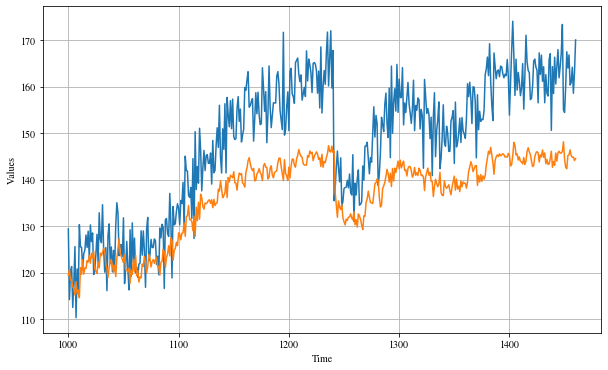

In [11]:
# 课程中的预测接下来序列的方法(使用整个序列，浪费时间)
forcast = []
for time in range(len(series)-window_size):
    forcast.append(model.predict(series[time:time+window_size][np.newaxis]))
forcast = forcast[train_size-window_size:]
result = np.array(forcast)[:,0,0]

plotSeries(test_time, test_values)
plotSeries(test_time, result, second=True)
checkError(test_values, result)

均方误差: 186.93507
平均绝对误差: 11.960475


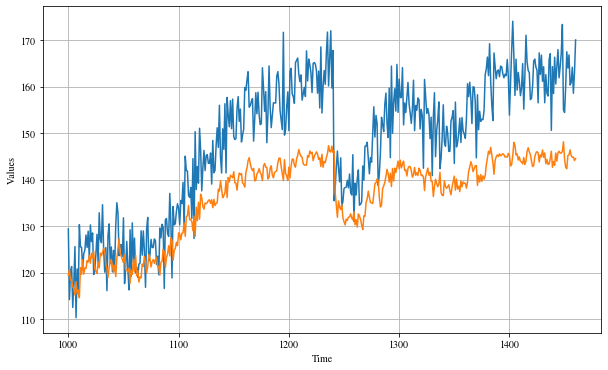

In [12]:
# 优化过的方法，只使用后半段序列，结构一样，时间大幅减小
forcast1 = []
new_series = series[train_size-window_size:]
for time in range(len(new_series)-window_size):
    forcast1.append(model.predict(new_series[time:time+window_size][np.newaxis]))
result1 = np.array(forcast1)[:,0,0]

plotSeries(test_time, test_values)
plotSeries(test_time, result1, second=True)
checkError(test_values, result1)

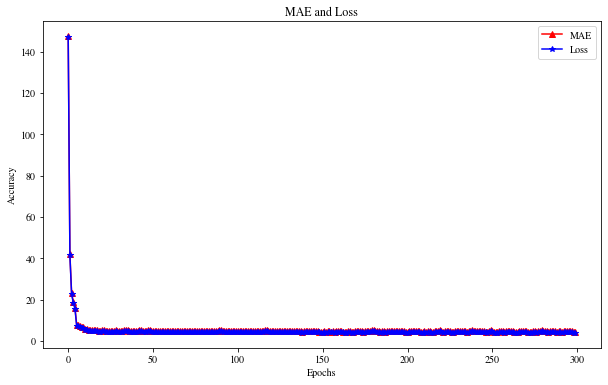

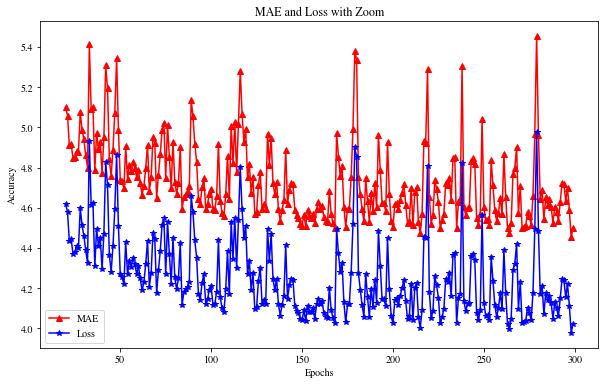

In [13]:
# 显示结果列表
plotHistory(history, 20)